In [1]:
import tensorflow as tf
import tools.mnist3 as mnist_tools
import tools.svhn as svhn_tools
import tools.semisup as semisup
import numpy as np
import architectures as arch

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
mnist_train_images, mnist_train_labels = mnist_tools.get_data('train')
mnist_test_images, mnist_test_labels = mnist_tools.get_data('test')
svhn_train_images, svhn_train_labels = svhn_tools.get_data('train')
svhn_test_images, svhn_test_labels = svhn_tools.get_data('test')

Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
mnist_test_images[0].shape

(28, 28, 3)

In [4]:
# labeled samples used per class
sup_per_class = 10
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 10
unsup_batch_size = 100


learning_rate = 1e-3
decay_steps = 5000
decay_factor = 0.33
visit_weight = 0.0

max_steps = 2000
eval_interval = 500

log_dir = "logs/model-svhn-mnist"

seed = None

IMAGE_SHAPE = svhn_tools.IMAGE_SHAPE
NUM_LABELS = svhn_tools.NUM_LABELS

# gets sup_per_class samples for each class

# [10 (classes), 10 (samples), 28, 28, 1]

sup_by_label = semisup.sample_by_label(svhn_train_images, svhn_train_labels,
                        sup_per_class, NUM_LABELS, seed)

**dataset: SVHN**

**target: MNIST**

In [5]:
TARGET_SHAPE = mnist_tools.IMAGE_SHAPE
TEST_SHAPE   = TARGET_SHAPE

image_shape = IMAGE_SHAPE
new_shape   = TARGET_SHAPE
emb_size    = 128

In [6]:
image_shape

[32, 32, 3]

In [7]:
from ipywidgets import IntProgress, Layout
from functools import partial

graph = tf.Graph()


with graph.as_default():
    
    unsup_data = up.create_input(mnist_train_images, mnist_train_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,t_unsup_labels = unsup_it.get_next()
    
    
    sup_data = up.create_per_class_inputs(sup_by_label, sup_per_batch)
    sup_it   = sup_data.make_one_shot_iterator()
    
    model_func = partial(
        arch.svhn_model,
        new_shape=new_shape,
        img_shape=image_shape,
        emb_size=emb_size
    )
    
    model = semisup.SemisupModel(model_func, NUM_LABELS, IMAGE_SHAPE,
                                 test_in=tf.placeholder(np.float32, [None] + TEST_SHAPE, 'test_in')
                                )
    
    item       = sup_it.get_next()
    temp_unzip = (list(zip(*item)))
    t_sup_images, t_sup_labels = tf.concat(temp_unzip[0], 0), tf.concat(temp_unzip[1], 0)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight)
    model.add_logit_loss(t_sup_logit, t_sup_labels)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    
    saver = tf.train.Saver()

---------
Variables: name (type shape) [size]
---------
net/conv1/weights:0 (float32_ref 3x3x3x32) [864, bytes: 3456]
net/conv1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_3/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_3/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_3/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_3/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:

In [44]:
test_images = mnist_test_images
test_labels = mnist_test_labels


from IPython.display import display

f = IntProgress(min=0, max=max_steps, layout= Layout(width="90%")) # instantiate the bar
display(f) # display the bar

with tf.Session(graph=graph) as sess:
    sess.run(unsup_it.initializer)
    sess.run(tf.global_variables_initializer())
    
    epoch = 1
    
    for step in range(max_steps):
        try:
            _, summaries = sess.run([train_op, summary_op])
        except tf.errors.OutOfRangeError:
            sess.run(unsup_it.initializer)
            epoch += 1
            _, summaries = sess.run([train_op, summary_op])
            
        f.value = step
        f.description = f"Ep{epoch}:{step}/{max_steps}"
        if (step + 1) % eval_interval == 0 or step == 99:
            print('Step: %d' % step)
            test_pred = model.classify(test_images).argmax(-1)
            conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
            test_err = (test_labels != test_pred).mean() * 100
            print(conf_mtx)
            print('Test error: %.2f %%' % test_err)
            print()
    
            test_summary = tf.Summary(
                value=[tf.Summary.Value(
                    tag='Test Err', simple_value=test_err)])
    
            summary_writer.add_summary(summaries, step)
            summary_writer.add_summary(test_summary, step)

            print(f"saving model - step {model.step}")
            saver.save(sess, log_dir, global_step=model.step)

IntProgress(value=0, layout=Layout(width='90%'), max=2000)

Step: 99
[[350   4   0  30   0 580  14   1   1   0]
 [  0 605   0   2   0   1 525   0   2   0]
 [ 27  16  54  50   8  25  85   6 759   2]
 [ 20  23  20  15 561 124  39   9 186  13]
 [190  30   5 158   7  72  80  42  63 335]
 [  5   6   1 110 233 446  48   9  27   7]
 [ 94   1   0 682   1  16 129   0  35   0]
 [  6  62 490   0   0  24  53 348  37   8]
 [ 12  13  50  25  35  48 226   9 517  39]
 [191  43  35  13  37  75  27  83  62 443]]
Test error: 70.86 %

saving model - step <tf.Variable 'global_step:0' shape=() dtype=int64_ref>
Step: 499
[[430  28   0  11   0 488   9   2  12   0]
 [  0 694   1   0   0   0 436   0   4   0]
 [  3  15 104   3   3   4  24   6 868   2]
 [  7  25  19   3 650  55   3  10 221  17]
 [217  67   2  44   2   2   2  44  32 570]
 [  7  22   1  49 255 487   7  14  33  17]
 [117   5   1 707   2  11  98   0  13   4]
 [  6  46 468   0   0   4  10 439  48   7]
 [ 12 103  70  12  43  36  69  11 475 143]
 [168  68  25   4   7  13   2 164   7 551]]
Test error: 67.17 %

sa

In [8]:

train_step = 2000
model_checkpoint = f"{log_dir}-{train_step}"

with tf.Session(graph=graph) as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, model_checkpoint)
    
    sess.run(unsup_it.initializer)
    labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
    embedded_unsup = sess.run(t_unsup_emb)

INFO:tensorflow:Restoring parameters from logs/model-svhn-mnist-2000


In [9]:
similarity = embedded_sup.dot(embedded_sup.T)

labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

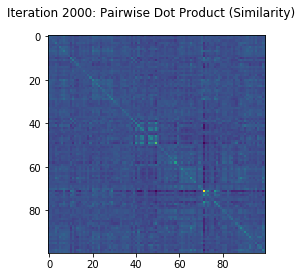

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.suptitle("Iteration 2000: Pairwise Dot Product (Similarity)")
plt.imshow(similarity)

INFO:tensorflow:Restoring parameters from logs/model-svhn-mnist-100
INFO:tensorflow:Restoring parameters from logs/model-svhn-mnist-500
INFO:tensorflow:Restoring parameters from logs/model-svhn-mnist-1000
INFO:tensorflow:Restoring parameters from logs/model-svhn-mnist-2000
Squared Euclidean Distance


<Figure size 432x288 with 0 Axes>

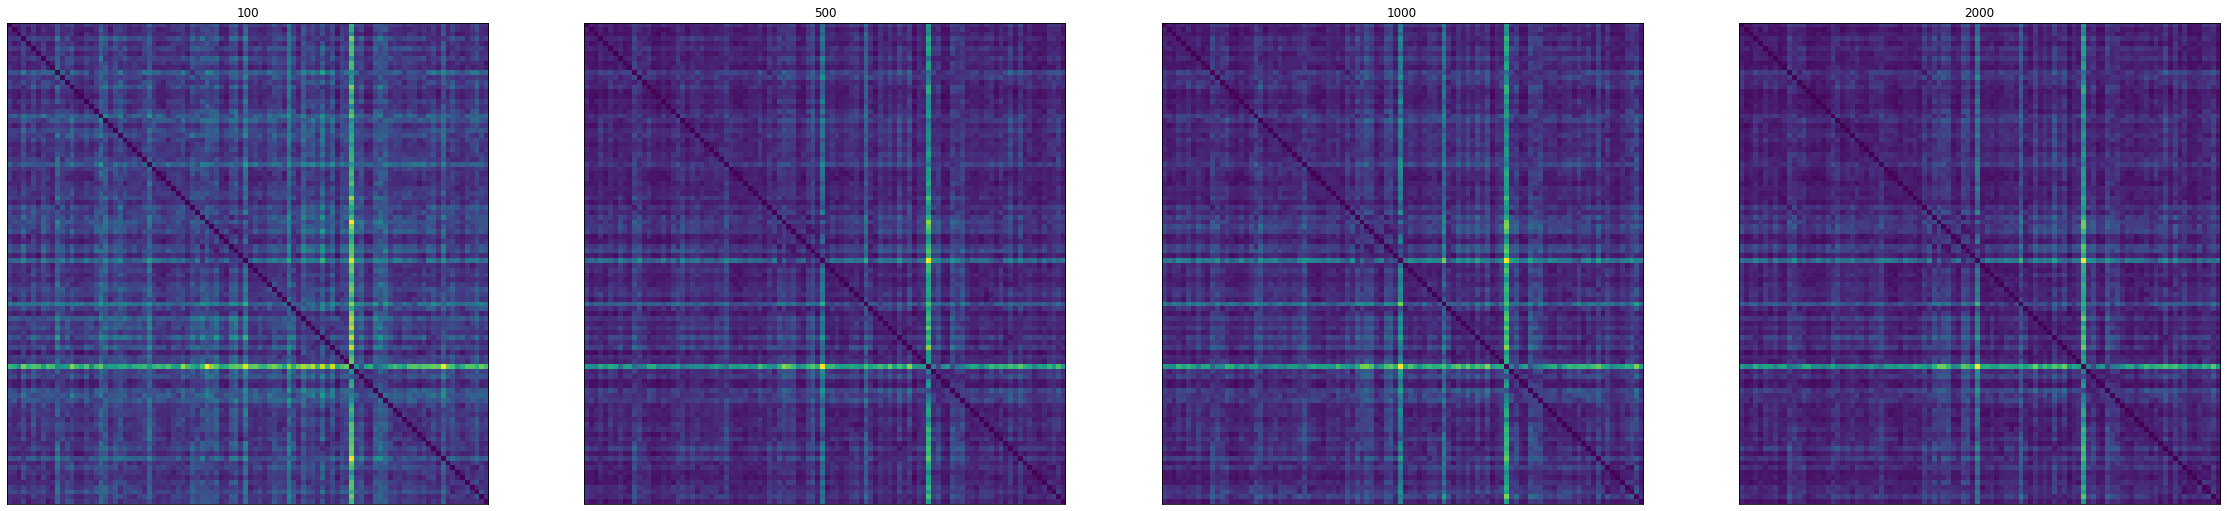

In [11]:
from tools.analyzer import Distance
import tools.analyzer as ana

def get_similarity(train_step, model_checkpoint, dist_func):
    
    with tf.Session(graph=graph) as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, model_checkpoint + "-" + str(train_step))
        
        sess.run(unsup_it.initializer)
        labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
        embedded_unsup = sess.run(t_unsup_emb)
        
    similarity = ana.get_pairwise_distance(
        embedded_sup, 
        dist_func
    )
    return similarity
    
dist_func = Distance.l2
similarities = []
labels = []
similarities.append(get_similarity(100, log_dir, dist_func))
labels.append(100)
similarities.append(get_similarity(500, log_dir, dist_func))
labels.append(500)
similarities.append(get_similarity(1000, log_dir, dist_func))
labels.append(1000)
similarities.append(get_similarity(2000, log_dir, dist_func))
labels.append(2000)

fig = plt.figure()
print("Squared Euclidean Distance")
vis.imshow(similarities, figsize=(50,50), labels=labels, imgwidth=100)

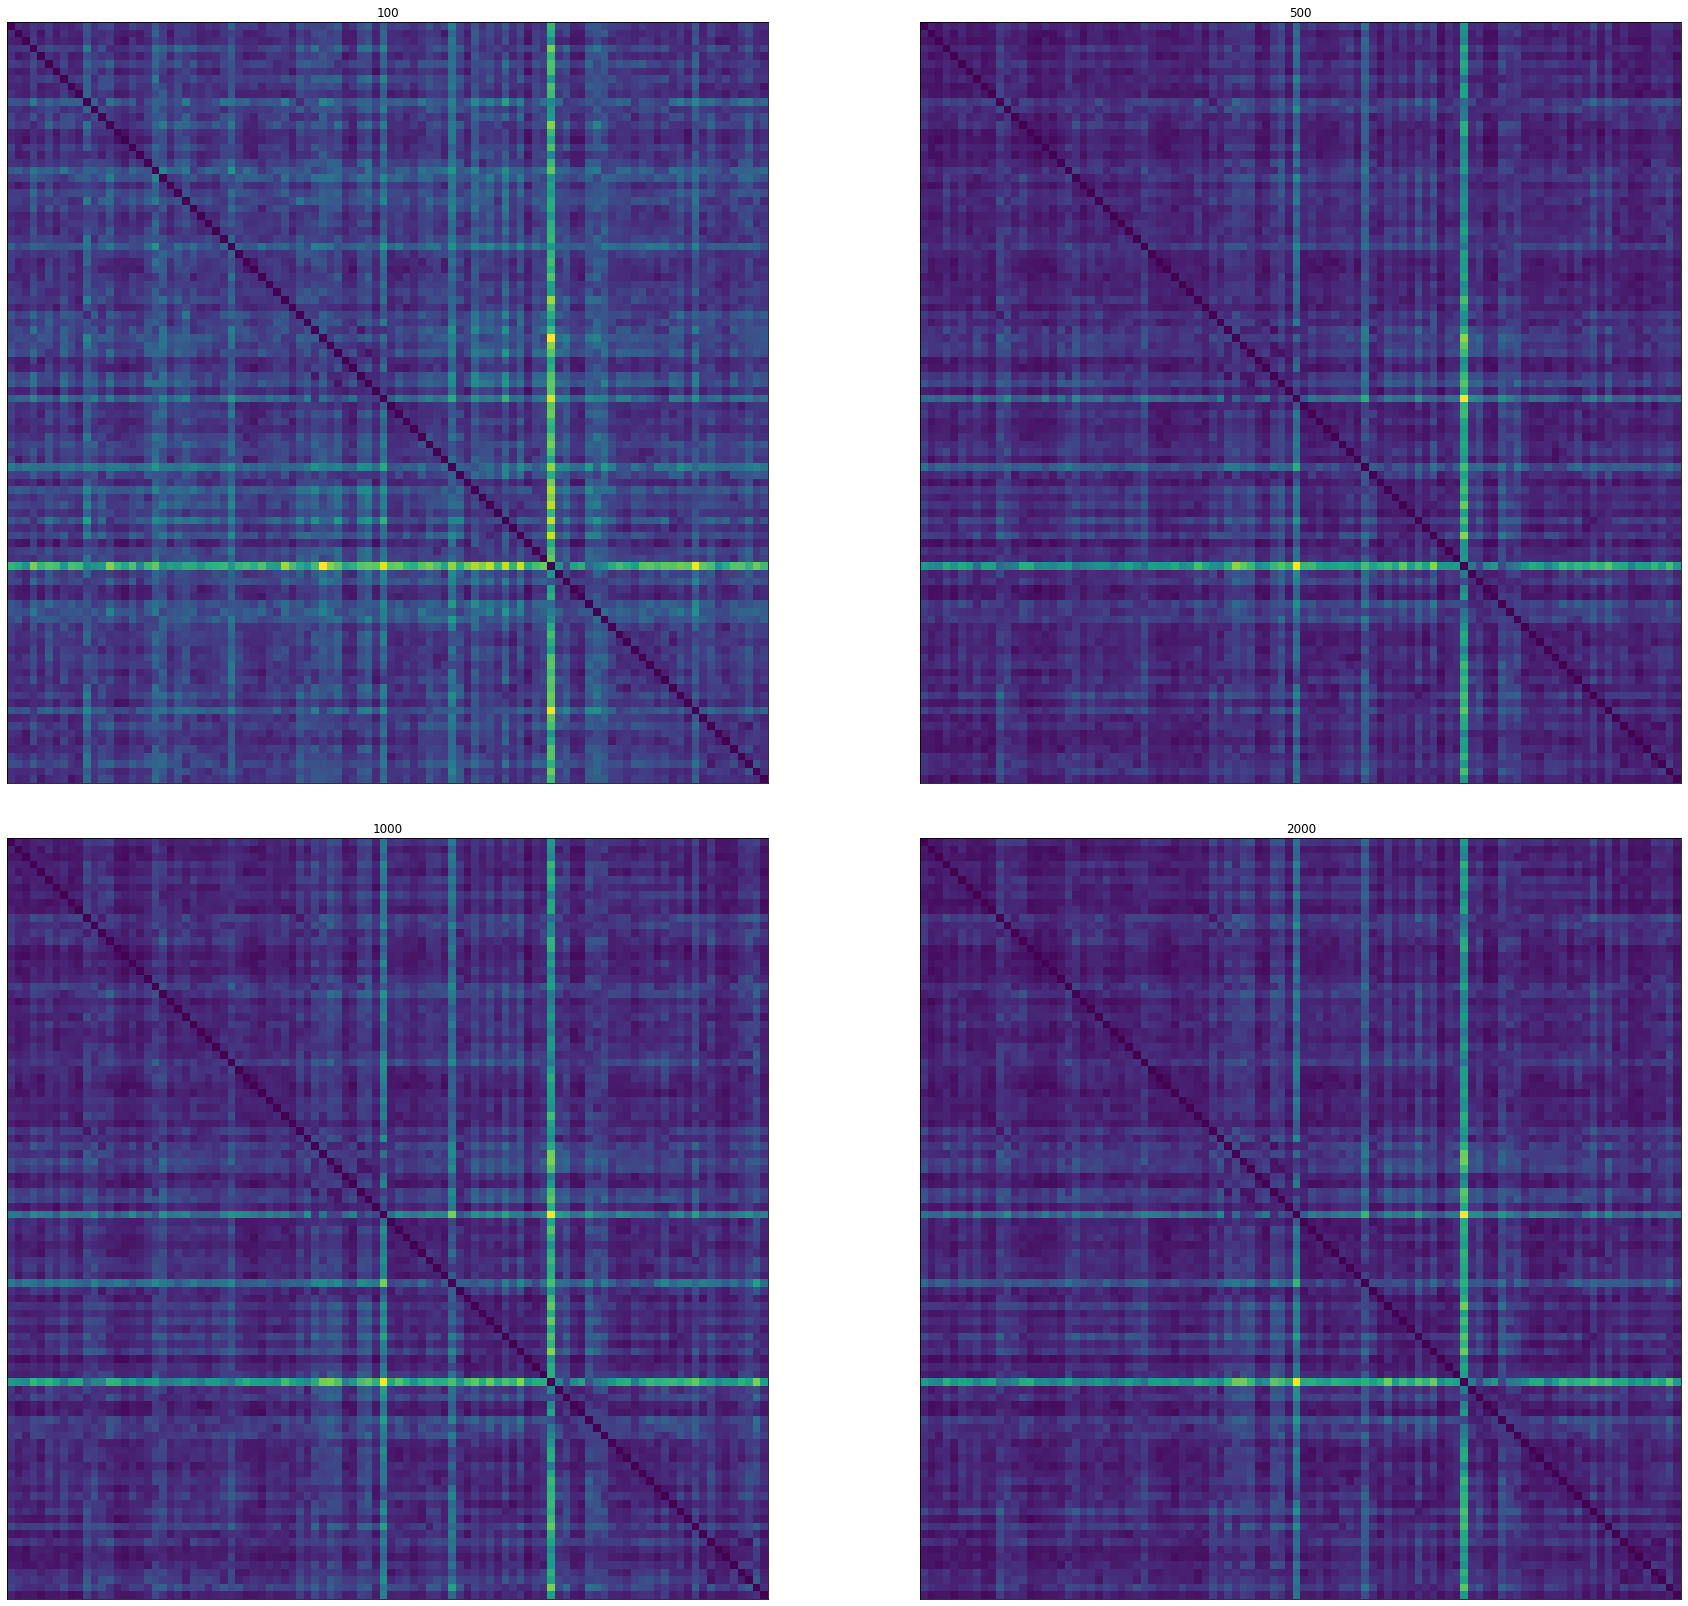

In [12]:
vis.imshow(similarities, figsize=(30,30), num_row=2,hspace=0, labels=labels, imgwidth=100)

In [13]:
def get_embedded(train_step, model_checkpoint):
    with tf.Session(graph=graph) as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, model_checkpoint + "-" + str(train_step))
        
        sess.run(unsup_it.initializer)
        labels_, embedded_sup = sess.run([t_sup_labels, t_sup_emb])
        embedded_unsup = sess.run(t_unsup_emb)
    
    stacked = np.vstack((embedded_sup, embedded_unsup))
        
    return stacked

def get_similarity(stacked, dist_func):
    
    similarity = ana.get_pairwise_distance(
        stacked, 
        dist_func
    )
    return similarity

def retrieve_similarity(train_step, model_checkpoint, dist_func):
    stacked = get_embedded(train_step, model_checkpoint)   
    return get_similarity(stacked, dist_func)
    
dist_func = Distance.l1
similarities = []
labels = []
similarities.append(retrieve_similarity(100, log_dir, dist_func))
labels.append(100)
similarities.append(retrieve_similarity(500, log_dir, dist_func))
labels.append(500)
similarities.append(retrieve_similarity(1000, log_dir, dist_func))
labels.append(1000)
similarities.append(retrieve_similarity(2000, log_dir, dist_func))
labels.append(2000)

INFO:tensorflow:Restoring parameters from logs/model-svhn-mnist-100
INFO:tensorflow:Restoring parameters from logs/model-svhn-mnist-500
INFO:tensorflow:Restoring parameters from logs/model-svhn-mnist-1000
INFO:tensorflow:Restoring parameters from logs/model-svhn-mnist-2000


In [14]:
similarities[0].shape

(200, 200)

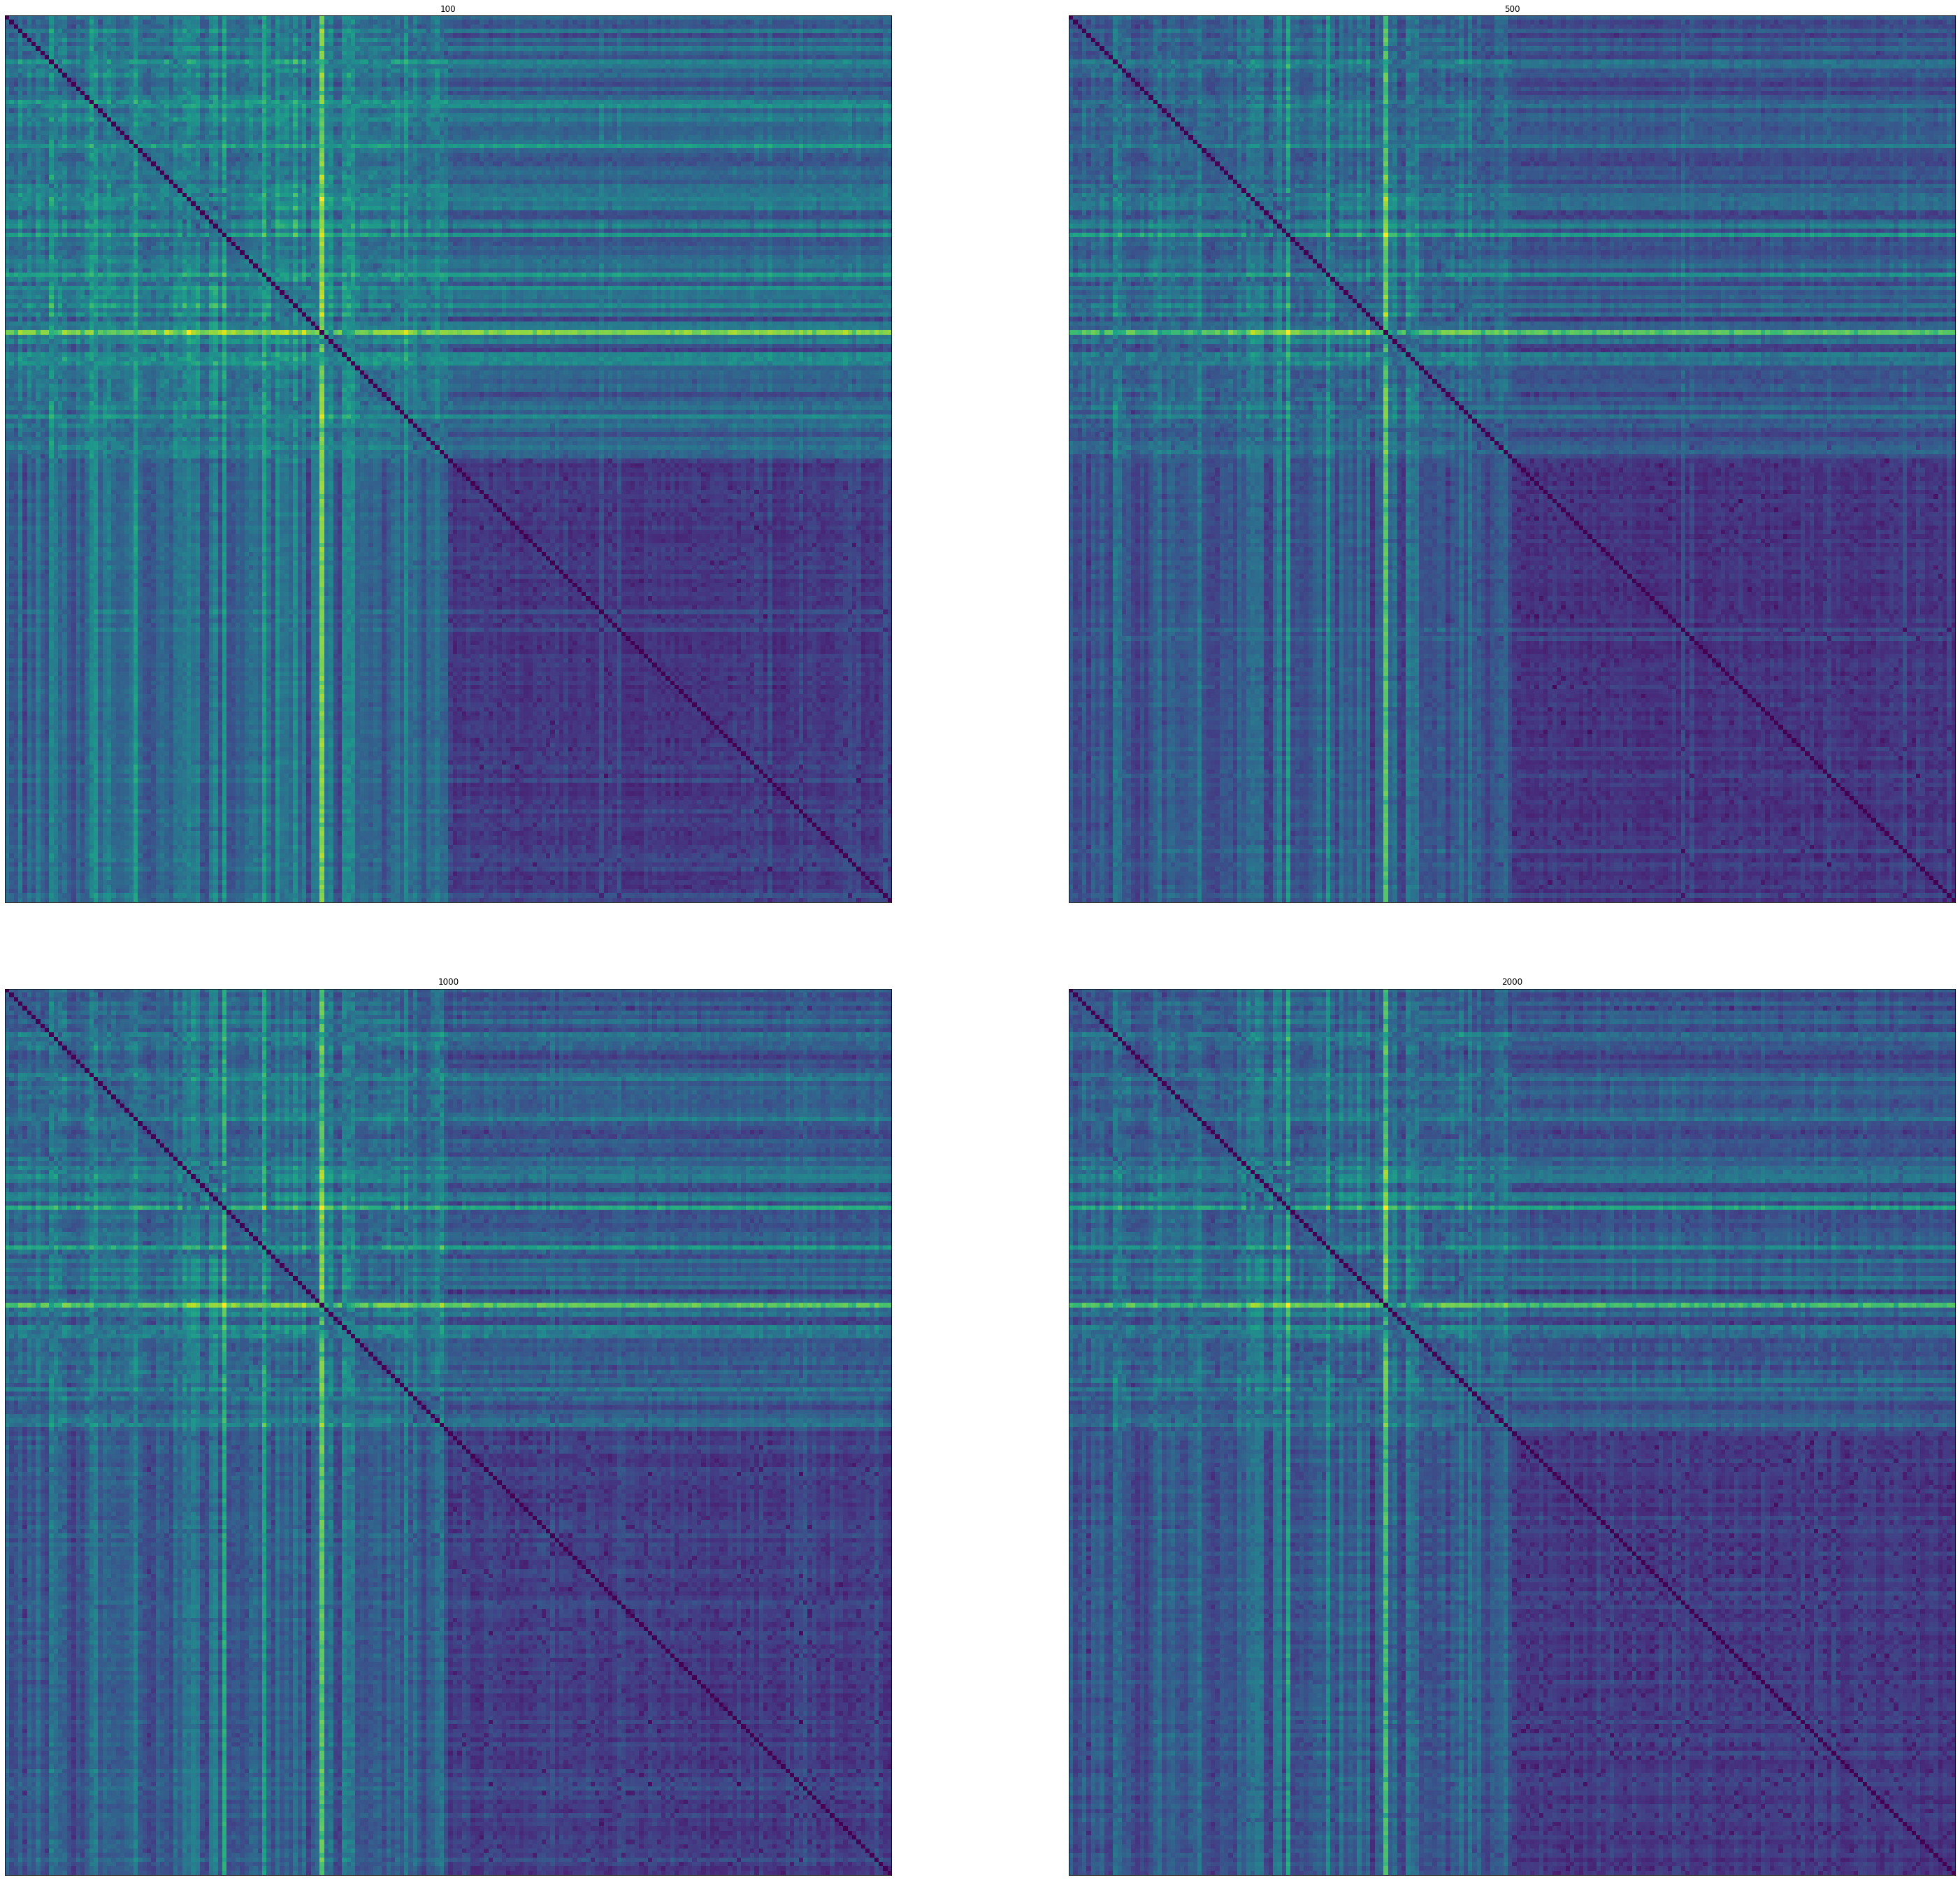

In [16]:
vis.imshow(similarities, figsize=(50,50), num_row=2,hspace=0.05, labels=labels, imgwidth=200)

In [17]:
from ipywidgets import FloatSlider
from IPython.html.widgets import *

stacked100 = get_embedded(100, log_dir)
stacked2000 = get_embedded(2000, log_dir)

interact(
    lambda sigma: vis.imshow(
        [
            get_similarity(stacked100, Distance.get_gaussian_k(sigma)),
            get_similarity(stacked2000, Distance.get_gaussian_k(sigma)),
        ], figsize=(50,50), hspace=0.05, labels=[100,2000], imgwidth=200
    ),
    sigma = FloatSlider(
        value=1,
        min=0.5,
        max=10.0,
        step=0.1,
        description='Effect of Gaussian Kernel',
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )
)

INFO:tensorflow:Restoring parameters from logs/model-svhn-mnist-100


/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


INFO:tensorflow:Restoring parameters from logs/model-svhn-mnist-2000


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Effect of Gaussian Kernel',…

<function __main__.<lambda>(sigma)>